#### Using WIN@ 

Downloaded as .csv using Metatrader 5 

#### Create my Candle Pattern predictor for next hour

In [1]:
%matplotlib inline

In [2]:
pwd

'C:\\Users\\alferreira\\Documents\\stocks\\prototypes'

In [3]:
cd ..

C:\Users\alferreira\Documents\stocks


In [4]:
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
import seaborn as sns
from algos.util import progressbar
from algos import prepareData, meta5Ibov
from algos.nn import torchNN, torchCV, torchUtil
import torch as th
import scipy

### Load Dow Jones 1 Century Data

In [5]:
cd data

C:\Users\alferreira\Documents\stocks\data


In [6]:
pwd

'C:\\Users\\alferreira\\Documents\\stocks\\data'

### Devido ao desdobramento de ações, divisão de ações melhor usar o Ibovespa

In [7]:
dow = pd.read_csv('WIN@_H1_2013_2018.csv', delimiter='\t',
                 na_values=['null', '0'], 
                names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Volume', 'Spread'],
                header=0)

In [8]:
dow.tail()

,Date,Time,Open,High,Low,Close,TickVol,Volume,Spread
11663,2019.02.08,14:00:00,94150,94275,93440,94160,253714,921049,NaN
11664,2019.02.08,15:00:00,94155,95025,94065,94945,190812,781287,NaN
11665,2019.02.08,16:00:00,94945,95250,94675,95035,153068,603484,NaN
11666,2019.02.08,17:00:00,95040,95620,94970,95425,112216,486874,NaN
11667,2019.02.08,18:00:00,95425,95515,95070,95070,8830,39156,NaN


In [9]:
# for yahooo finance data
#dow['Close'] = dow['Adj Close']  
dow.drop(['TickVol', 'Spread'], axis=1, inplace=True) # Close is better than Adjusted Close
# 1/3%

In [10]:
dow.isnull().sum().sum() # total number of cells with nans 

0

In [11]:
dow.dropna(inplace=True)

Convert to datetime Date

In [12]:
dow.Date = pd.to_datetime(dow.Date+' '+dow.Time)

In [13]:
dow.head(2)

,Date,Time,Open,High,Low,Close,Volume
0,2013-12-12 09:00:00,09:00:00,77531,77982,77469,77834,14143
1,2013-12-12 10:00:00,10:00:00,77826,78106,77756,77826,24654


In [14]:
dow.set_index(dow.Date, drop=True, inplace=True);

In [15]:
dow.drop(['Date', 'Time'], axis=1, inplace=True)

### Fake Algo Random Data test

In [16]:
dow.shape

(11668, 5)

In [17]:
#dow.iloc[:, :] = np.abs(np.random.rand(11668, 5)*10000)

### **Let's create the up/down class for each day compared with the previous**

In [18]:
dow['updown'] = np.nan

We are pushing the days were there were no movement to the down. 

In [19]:
# candles on close
dow.updown.iloc[1:] = dow.iloc[1:].Close.values > dow.iloc[:-1].Close.values 
dow.updown = dow.updown.map(lambda x: 1 if x else 0)

C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
dow.updown.values[0] = -1 # first day has no info

In [21]:
dow.head()

,Open,High,Low,Close,Volume,updown
Date,,,,,,
2013-12-12 09:00:00,77531,77982,77469,77834,14143,-1
2013-12-12 10:00:00,77826,78106,77756,77826,24654,0
2013-12-12 11:00:00,77826,77888,77446,77857,29381,1
2013-12-12 12:00:00,77865,78028,77570,77625,26368,0
2013-12-12 13:00:00,77625,77725,77330,77531,25854,0


In [22]:
dow.tail()

,Open,High,Low,Close,Volume,updown
Date,,,,,,
2019-02-08 14:00:00,94150,94275,93440,94160,921049,1
2019-02-08 15:00:00,94155,95025,94065,94945,781287,1
2019-02-08 16:00:00,94945,95250,94675,95035,603484,1
2019-02-08 17:00:00,95040,95620,94970,95425,486874,1
2019-02-08 18:00:00,95425,95515,95070,95070,39156,0


In [23]:
#dow.Close.resample('D') # maybe use this someday

### Lets take a look on that data

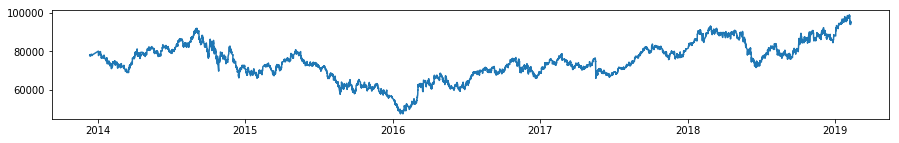

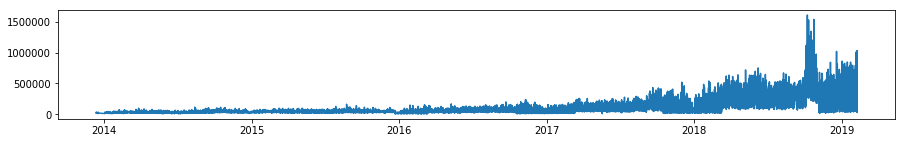

In [24]:
plt.figure(figsize=(15,2))
plt.plot(dow.Close) # dow.index.map(lambda x: x.year)
plt.figure(figsize=(15,2))
plt.plot(dow.Volume) # dow.index.map(lambda x: x.year)

In [25]:
dow.Volume.head()

Date
2013-12-12 09:00:00    14143
2013-12-12 10:00:00    24654
2013-12-12 11:00:00    29381
2013-12-12 12:00:00    26368
2013-12-12 13:00:00    25854
Name: Volume, dtype: int64

#### Since the data is `exponentially` increasing lets see if we can detrend it.
Lets first use a simple log function

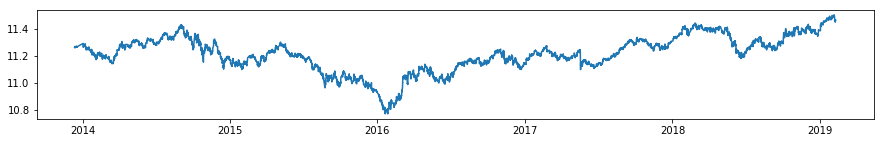

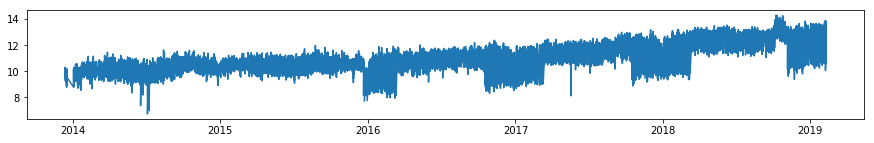

In [26]:
plt.figure(figsize=(15,2))
plt.plot(np.log(dow.Close)) # dow.index.map(lambda x: x.year)
plt.figure(figsize=(15,2))
plt.plot(np.log(dow.Volume)) # dow.index.map(lambda x: x.year)

In [27]:
for column in dow.columns[:-1]: # all less the up/down class
    dow.loc[:, column] = np.log(dow.loc[:, column].values)

For simplicity a linear detrend to solve the rest.  First try did not pose nice results.  
Use it just for viewing. 

But since we are trying to analyse a specific time-scale 5/6 days all other variations are noise to us. So let's try to remove a moving average of three weeks (3*5=15 days). Need to figure out a better.  

In [28]:
from scipy.signal import detrend
dowv = dow.copy()
dowv.values[:, :5] = detrend(dow.values[:,:5], axis=0, type='linear')

Text(0.5, 1.0, 'Just for viewing data')

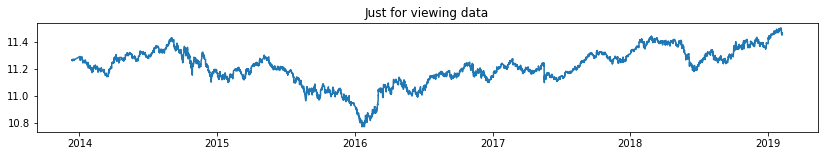

In [29]:
plt.figure(figsize=(14,2))
plt.plot(dowv.Close)
plt.title('Just for viewing data')

In [30]:
import talib as ta

In [31]:
len(dow)

11668

In [32]:
# this will need to change to a EMA or SMA due future data dependence
for col in range(5):
    #trend = np.convolve(dow.iloc[:, col], np.ones((15,))/15, mode='valid') 
    trend = ta.SMA(dow.iloc[:, col].values.astype(np.double), 2)
    #dow.iloc[7:-7, col] -= trend # to fit at the center -7 + 7 samples are border
    dow.iloc[:, col] -= trend # to fit at the center -7 + 7 samples are border
# dow.drop(dow.index[:7], inplace=True) # due border effect
# dow.drop(dow.index[-7:], inplace=True)

In [33]:
dow.dropna(inplace=True) # drop first nan value and meaningless UpDown value

In [34]:
len(dow)

11667

In [35]:
dowv = dowv.loc[dow.index] # update the viewing 

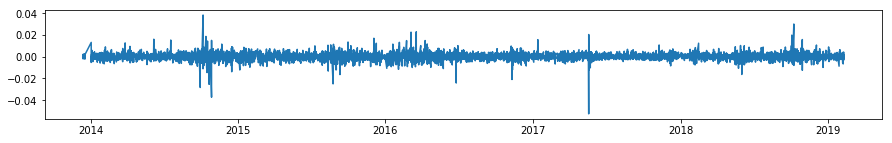

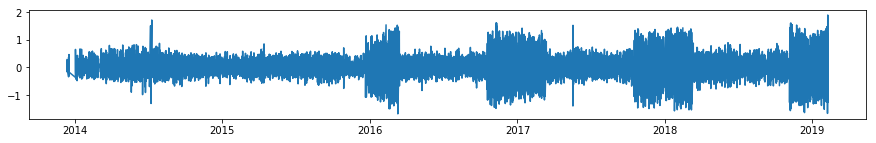

In [36]:
plt.figure(figsize=(15,2))
plt.plot(dow.Close) # dow.index.map(lambda x: x.year)
plt.figure(figsize=(15,2))
plt.plot(dow.Volume) # dow.index.map(lambda x: x.year)

For while, let inflation be!   
Will just calculate pattern of candles.   

In [37]:
dow['sup'] = np.nan

We are pushing the days were there were no movement to the down. 

In [38]:
# candles on close
dow.sup.iloc[1:] = dow.iloc[1:].Close.values > dow.iloc[:-1].Close.values 
dow.sup = dow.sup.map(lambda x: 1 if x else 0)

In [39]:
#dow.sup.values[0] = 0 # first day has no info - but lets not contaminated the mean

Let's drop the first sample due no info and nans on the **trend** removed

In [40]:
dow = dow[1:]
dowv = dowv[1:]

In [41]:
dowv['sup'] = dow.sup.copy()

### Lets Standardize data before creating the training Vector or Feature Vector X

From the histograms we can see there is no class in-balance at first look. 

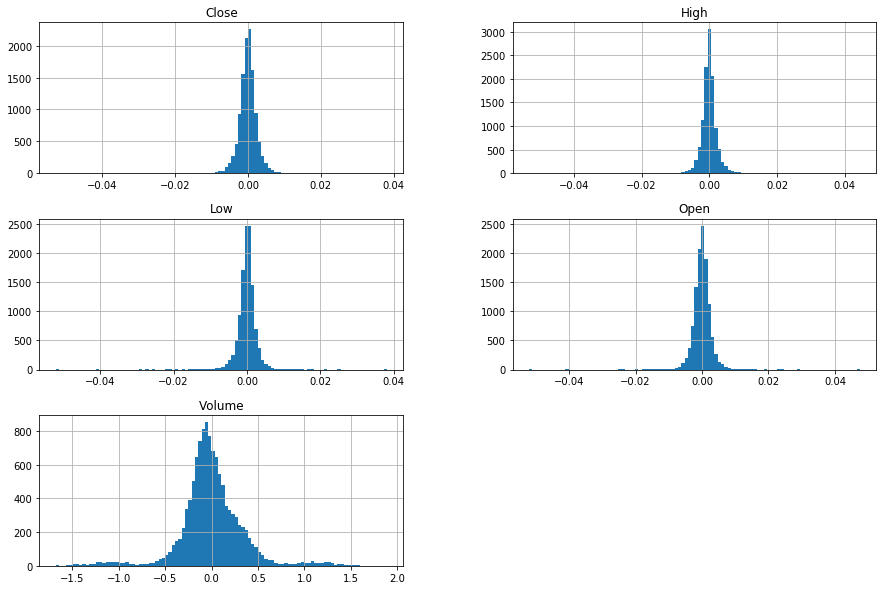

In [42]:
dow.iloc[:, :5].hist(bins=100, figsize=(15,10));

In [43]:
dow.head(1)

,Open,High,Low,Close,Volume,updown,sup
Date,,,,,,,
2013-12-12 11:00:00,1.776357e-15,-0.001397,-0.001997,0.000199,0.087705,1,1


In [44]:
newcolumns=dow.columns[:-2].tolist()
newcolumns.extend(['sup', 'updown'])
dow = dow.reindex(columns=newcolumns)
dowv = dowv.reindex(columns=newcolumns)

In [45]:
dow.head(1)

,Open,High,Low,Close,Volume,sup,updown
Date,,,,,,,
2013-12-12 11:00:00,1.776357e-15,-0.001397,-0.001997,0.000199,0.087705,1,1


In [46]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

In [47]:
quantile_transformer = preprocessing.QuantileTransformer(
    output_distribution='normal', random_state=0)

X_trans = quantile_transformer.fit_transform(dow.values[:,:-2])

In [48]:
X_trans.shape

(11666, 5)

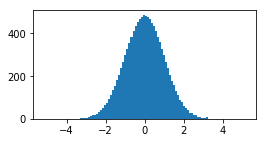

In [49]:
plt.figure(figsize=(4,2))
plt.hist(X_trans[:,4], bins=100);

In [50]:
np.mean(X_trans[:,4]), np.std(X_trans[:,4])

(-0.00010077143354168453, 1.000485200648405)

In [51]:
X_trans.shape

(11666, 5)

In [52]:
X = np.array(X_trans)
#X[:,:5] = X_trans[:,:]
#X[:, 5] = dow.values[:,-2]
#X[:, 5] = (X[:, 5] - X[:, 5].mean())/X[:, 5].std() # normalize variance=1 mean=0

In [53]:
np.mean(X, axis=0)

array([-1.53773660e-05, -2.84141399e-05, -1.00858225e-05,  1.47423111e-05,
       -1.00771434e-04])

In [54]:
np.std(X, axis=0)

array([1.0001176 , 1.00009352, 1.00038068, 1.00028142, 1.0004852 ])

### Lets make the feature vector X


We will shift forward 5 days so we can use the last ones to predict the next.  
So we can use previous days information to train to predict next one.  

We will train like this:

[-5, -4, -3, -2, -1] -> [0]  
[-4, -3, -2, -1,  0] -> [1]  
[-3, -2, -1,  0,  1] -> [2]  
        ...              
 
but each day O, H, L, C, V will be a row so:

[-5, -4, -3, -2, -1] -> [0]
is  

[O[-5], H[-5], L[-5], C[-5], V[-5], O[-4], H[-4], L[-4], C[-4], V[-4] ... O[-1], H[-1], L[-1], C[-1], V[-1]] -> [0]

Meaning training or feature vector will have 5*5 = 25 dimension. 

In [55]:
data = X # we don't use the training class

In [56]:
pdays=21 # previous hours ~ 5 days on H2 time-frame

In [57]:
data = dow.iloc[:, :-2].values

In [58]:
# data = np.array([1, 3, 4, 5, 6, 3])
# pdays=3

In [59]:
from numba import jit

@jit(nopython=True)
def Xbackward_array(data, nprevious, ncolumns):
    X = np.zeros((len(data)-nprevious+1, nprevious*ncolumns))
    # maybe using np.tile with np.repeat is faster but dont know how
    for i in range(nprevious, len(data)+1):
        X[i-nprevious,:] = data[i-nprevious:i].flatten()
    return X

[1, 3, 4, 5, 6, 3]

[1, 3, 4]  
[3, 4, 5]  
[4, 5, 6]  
[5, 6, 3]  

In [60]:
assert np.alltrue( 
    Xbackward_array(np.array([1, 3, 4, 5, 6, 3]), 3, 1) ==
    np.array([[1, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 3]]))

In [61]:
X = Xbackward_array(data, pdays, 5)

In [62]:
len(X)

11646

### Lets make the class vector or target vector Y

In [63]:
#Y = dow.updown[pdays:]
Y = dow.sup[pdays:]
Y = Y.values

In [64]:
#Y = Y[1:]

In [65]:
len(X), len(Y)

(11646, 11645)

In [66]:
Xfuture = X[-1] # last day/hour is prediction of future
X = X[:-1] # this is training data

In [67]:
#X[-1]

In [68]:
Y[-2]

1

In [69]:
#dow.tail(pdays)

In [70]:
dow = dow[pdays:] # the first days dont cannot use class for training so we dont need them
dowv = dowv[pdays:] # same for plotting

In [71]:
import sklearn

In [72]:
print(sklearn.metrics.classification_report(dow.updown, dow.sup))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      5817
           1       0.75      0.74      0.75      5828

   micro avg       0.75      0.75      0.75     11645
   macro avg       0.75      0.75      0.75     11645
weighted avg       0.75      0.75      0.75     11645



In [73]:
#sns.jointplot(dow.updown, dow.sup, kind='kde')

#### Remember!

dowv has same number of row than X, Y vectors, indexes are syncronized

### Lets prepare the engine Torch

In [132]:
import importlib

In [133]:
importlib.reload(torchNN), importlib.reload(torchCV), importlib.reload(torchUtil)

(<module 'algos.nn.torchNN' from 'C:\\Users\\alferreira\\Documents\\stocks\\algos\\nn\\torchNN.py'>,
 <module 'algos.nn.torchCV' from 'C:\\Users\\alferreira\\Documents\\stocks\\algos\\nn\\torchCV.py'>,
 <module 'algos.nn.torchUtil' from 'C:\\Users\\alferreira\\Documents\\stocks\\algos\\nn\\torchUtil.py'>)

In [76]:
device = torchNN.getDevice()

In [77]:
device

device(type='cuda')

In [78]:
torchNN.setSeed(device, 25640) # reproducible

Train in ~ **2 month** and test on the subsequent **0.1 months**

training/valiation ratio of 90%

In [79]:
X, Y = torchUtil.binaryTensors(X, Y, device=device)

In [80]:
ntrain= 7*5*21
kfold = torchCV.sKFold(X, foldsize=ntrain, ratio=0.9)
nsplits = kfold.GetnSplits()
ntrain, ntest, npred = kfold.ntrain, kfold.ntest, kfold.npred
print('number of folds ', nsplits, 
      ' H1 of training ', ntrain, 
      ' H1 of validation ', ntest,
      ' H1 of prediction ', npred)

number of folds  10910  H1 of training  660  H1 of validation  74  H1 of prediction  1


Get a random begin on data of those n years

Locally normalize mean = 0 and variance to 1  
Specially for this 25 type of data/training, this should not be done here. 

In [81]:
#Xfold = (Xfold - Xfold.mean())/Xfold.std() # normalize variance=1 mean=0

In [165]:
# tensors
for start, sval, spred, end in kfold.SplitsRandn(1):
    Xt, yt = X[start:sval], Y[start:sval]
    Xs, ys = X[sval:spred], Y[sval:spred]
    # use :end on slicing to avoid using unsqueze
    Xp, yp = X[spred:end], Y[spred:end] # only ONE sample

#print(start, sval, spred, end)
print('unbalanced class percentage training ~: % {:.1f}'.format(100*((th.sum(yt).item()/(len(yt))-0.5))))
print('unbalanced class percentage validation~: % {:.1f}'.format(100*((th.sum(ys).item()/len(ys))-0.5)))

classifier = torchNN.BinaryNN(input_dim=X.shape[1], nneurons=[256, 256, 128, 128],
                              dropout=0.55, learn=8e-3, patience=100, device=device)

unbalanced class percentage training ~: % -0.9
unbalanced class percentage validation~: % -1.4


In [166]:
classifier.fit(Xt, yt, Xs, ys, epochs=8, batch=128, iscore=0.5, gma=0.99, learn=1e-3, verbose=True);

iteration : 2      train loss: 0.6939443 valid acc: 0.4864865 valid loss :0.6942016 learn r.: 0.0010000
iteration : 5      train loss: 0.6936806 valid acc: 0.4864865 valid loss :0.6938531 learn r.: 0.0009900
iteration : 8      train loss: 0.6934438 valid acc: 0.4864865 valid loss :0.6935480 learn r.: 0.0009801
iteration : 11     train loss: 0.6932498 valid acc: 0.4864865 valid loss :0.6932923 learn r.: 0.0009703
iteration : 14     train loss: 0.6931221 valid acc: 0.4864865 valid loss :0.6931254 learn r.: 0.0009606
iteration : 17     train loss: 0.6929831 valid acc: 0.5000000 valid loss :0.6929226 learn r.: 0.0009510
iteration : 20     train loss: 0.6928819 valid acc: 0.5135135 valid loss :0.6927592 learn r.: 0.0009415
iteration : 23     train loss: 0.6927809 valid acc: 0.5135135 valid loss :0.6925924 learn r.: 0.0009321
iteration : 26     train loss: 0.6926922 valid acc: 0.5135135 valid loss :0.6924628 learn r.: 0.0009227
iteration : 29     train loss: 0.6926021 valid acc: 0.5135135 va

In [167]:
for i in range(2):
    classifier.fineTune(Xs, ys, batch=128)

[################################################################################] 2/2
[################################################################################] 2/2


In [168]:
dowv.tail(2)

,Open,High,Low,Close,Volume,sup,updown
Date,,,,,,,
2019-02-08 17:00:00,11.462053,11.468137,11.461316,11.466096,13.095761,1,1
2019-02-08 18:00:00,11.466096,11.467039,11.462369,11.462369,10.575309,0,0


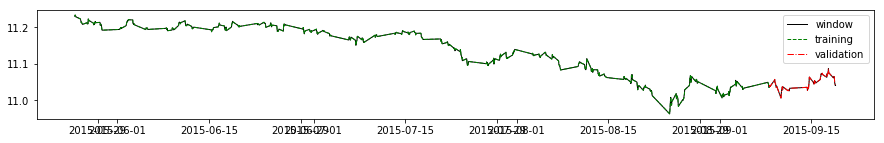

In [170]:
plt.figure(figsize=(15,2))
plt.plot(dowv.iloc[start:end].Close, 'k-', lw=1, label='window')
plt.plot(dowv.iloc[start:sval].Close, 'g--', label='training', lw=1)
plt.plot(dowv.iloc[sval:end].Close, 'r-.', label='validation', lw=1)
plt.legend()

In [171]:
classifier.prog.shape

torch.Size([17, 3])

Using a cut-off on model probability if not certain why should I trust?!  
Try to correct the cases where there is no up or down, just laterall variation or anything else with not that certainty

0.7 or 70% at least

In [172]:
classifier.score(Xs, ys)

0.5135135054588318

In [173]:
params = {'cutoff':0.51}

In [174]:
classifier.score(Xs, ys, **params)

data above probability cutoff: 1.00


0.5135135054588318

To think about...

That above indicates that validation must have a weight.   
Those samples that are more recent should receive a higher 'weight' somehow.

We cannot train too much on a validation set that is too far behind on time. 

Also there are breaking points when the market totally loose correlation from the past.  
For example above near end november.

### Best 78.4% on validation

- `gamma`  should not be too low (~0.9) otherwise we have overfitting on training set 
- a low `gamma` value makes it go to a local minima that is the validation minima

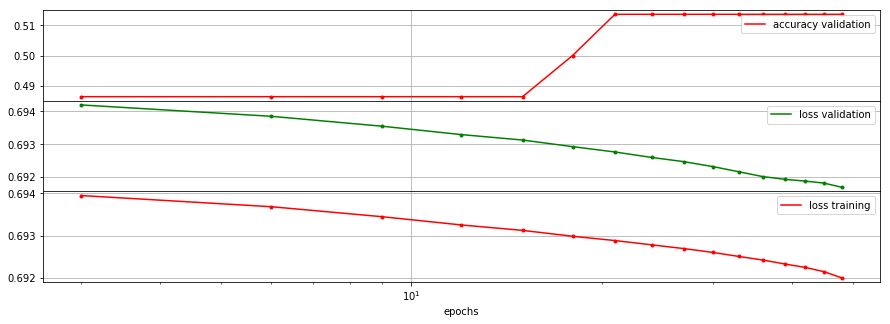

In [175]:
classifier.viewResults()

###  Results

Let's see latest forecasts.

In [176]:
dowv.tail(3)

,Open,High,Low,Close,Volume,sup,updown
Date,,,,,,,
2019-02-08 16:00:00,11.461053,11.464260,11.458205,11.462001,13.310475,0,1
2019-02-08 17:00:00,11.462053,11.468137,11.461316,11.466096,13.095761,1,1
2019-02-08 18:00:00,11.466096,11.467039,11.462369,11.462369,10.575309,0,0


### last 22 days / 22 * 2H hours

In [177]:
pdays=22
cutoff=0.7

In [178]:
classifier.score(Xs[-pdays:], ys[-pdays:], cutoff)

data above probability cutoff: 0.00


nan

### last 10 days / 10 * 2H hours

In [179]:
pdays=10
cutoff=0.5

In [180]:
classifier.score(Xs[-pdays:], ys[-pdays:], cutoff)

data above probability cutoff: 1.00


0.5999999940395355

## Today

In [181]:
classifier.predict(th.tensor(Xfuture, dtype=th.float, device=device).unsqueeze(dim=0))

(tensor([[0.5271, 0.4729]], device='cuda:0'), tensor([0], device='cuda:0'))

### Cross validation Sequential Folds 

In [182]:
importlib.reload(torchCV)

<module 'algos.nn.torchCV' from 'C:\\Users\\alferreira\\Documents\\stocks\\algos\\nn\\torchCV.py'>

In [183]:
# stand-by dont need this now, better use probabilyties before and test
# to find the best cut-off
# accuracy_clip = lambda m, x, y : torchCV.accuracy(m, x, y, cutoff=0.65)

In [184]:
classifier = torchNN.BinaryNN(input_dim=X.shape[1], nneurons=[256, 256, 256, 32],
                              dropout=0.6, learn=5e-3, patience=10, device=device)
params = {'epochs':9, 'batch':128, 'iscore':0.5, 'gma':0.92, 'verbose':False}

#### Run 100 cross-validations on the last n folds

- save predictions as well its probabilities
- pass params using dictionary for 'fit' method

In [186]:
ntrain=21*7*5

In [187]:
# torchCV.sCrossValidate(X, Y, classifier, foldsize=ntrain, cv=3, 
#                        fit_params=params, scores=[accuracy_clip], predict=True)
results = torchCV.sCrossValidate(X, Y, classifier, foldsize=ntrain, ratio=0.90, cv=25, fine=3, 
                       fit_params=params, kind='lastn', predict=True)

early stopped: no progress on validation#################........................] 38/54
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2
early stopped: no progress on validation#################........................] 38/54
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2
early stopped: no progress on validation#####################....................] 41/54
[################################################################################] 2/2
[################################################################################] 2/2
[####################################

[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2
early stopped: no progress on validation##########################...............] 44/54
[################################################################################] 2/2
[################################################################################] 2/2
[################################################################################] 2/2


In [188]:
metrics = pd.DataFrame(results, columns=['idx', 'trainac', 'validac', 'accpred', 'predb0', 'predb1', 'y' ])

### Need to run cross-validation again 



In [189]:
metrics.head()

,idx,trainac,validac,accpred,predb0,predb1,y
0,11643.0,0.509091,0.540541,0.0,0.555268,0.444732,1.0
1,11642.0,0.507576,0.540541,1.0,0.568145,0.431855,0.0
2,11641.0,0.507576,0.554054,0.0,0.547825,0.452175,1.0
3,11640.0,0.507576,0.567568,0.0,0.593401,0.406599,1.0
4,11639.0,0.507576,0.554054,1.0,0.530665,0.469335,0.0


In [190]:
metrics.idx = metrics.idx.values.astype(int)
metrics.y = metrics.y.values.astype(int)

#### What is the best cut-off

Better do interactvly cutting and calculating the percentage... of data  
should also vary at the same time the model score to see where is the best  
balance between data-percentage and accuracy. 

In [191]:
np.mean(metrics.accpred)

0.56

In [192]:
metrics['probmax'] = metrics.apply(lambda x:  max(x.predb0, x.predb1), axis=1)

C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


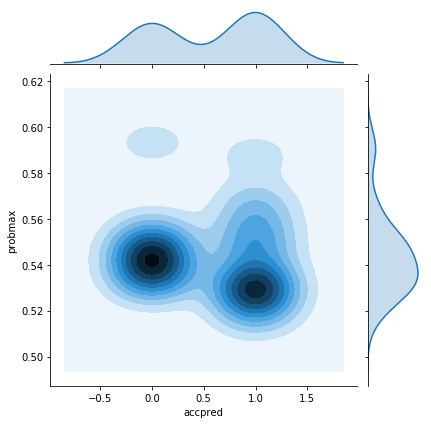

In [193]:
sns.jointplot(metrics.accpred, metrics.probmax, kind='kde')

Jointplot above suggests 0.8 of cut-off

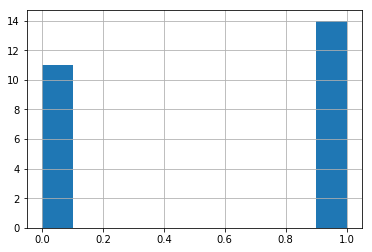

In [194]:
metrics.accpred.hist()

In [117]:
import talib as ta

### Average Accuracy by day

[0.25 0.25 0.5  0.75 1.  ]


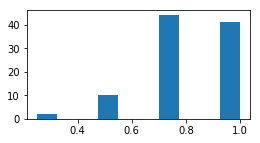

In [118]:
metrics['davpredac'] = ta.SMA(metrics.accpred.values, 4)
plt.figure(figsize=(4,2))
plt.hist(metrics.davpredac.dropna());
print(np.percentile(metrics.davpredac.dropna().values, (0, 1, 10, 50, 90)))
# davpredac_c = ta.SMA(metrics.predac_c.dropna().astype(np.double), 4)
# plt.figure(figsize=(4,2))
# plt.hist(davpredac_c.dropna());
# print(np.percentile(davpredac_c.dropna(), (0, 1, 10, 50, 90)))

### Average Accuracy by week

[0.75 0.75 0.75 0.85 0.9 ]


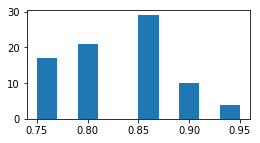

In [119]:
metrics['wavpredac'] = ta.SMA(metrics.accpred.values, 20)
plt.figure(figsize=(4,2))
plt.hist(metrics.wavpredac.dropna());
print(np.percentile(metrics.wavpredac.dropna().values, (0, 1, 10, 50, 90)))
# wavpredac_c = ta.SMA(metrics.predac_c.dropna().astype(np.double), 20)
# plt.figure(figsize=(4,2))
# plt.hist(wavpredac_c.dropna());
# print(np.percentile(wavpredac_c.dropna(), (0, 1, 10, 50, 90)))

In [120]:
metrics['modelscore'] = np.sqrt(metrics.trainac*metrics.validac)

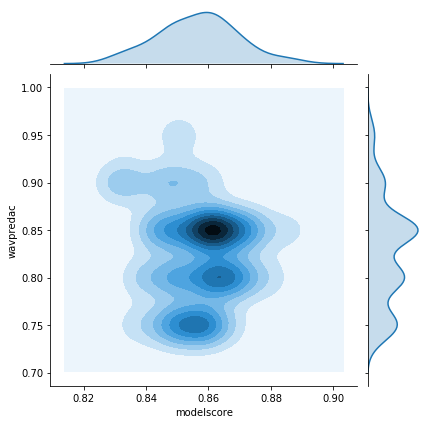

In [121]:
sns.jointplot(metrics.modelscore, metrics.wavpredac, kind='kde')

In [122]:
print(np.percentile(metrics.wavpredac[ metrics.modelscore > 0.525 ].dropna(), (0, 1, 10, 50, 90)))

[0.75 0.75 0.75 0.85 0.9 ]


In [123]:
len(metrics.wavpredac[ metrics.modelscore > 0.78 ].dropna())/len(metrics.wavpredac.dropna())

1.0

In [124]:
metrics[-10:]

,idx,trainac,validac,accpred,predb0,predb1,y,probmax,davpredac,wavpredac,modelscore
90,11553,0.856242,0.841808,1.0,0.000403,9.995973e-01,1,0.999597,0.75,0.75,0.848994
91,11552,0.875158,0.864407,1.0,1.000000,1.461305e-14,0,1.000000,0.75,0.80,0.869766
92,11551,0.853090,0.847458,1.0,0.000003,9.999974e-01,1,0.999997,1.00,0.80,0.850269
93,11550,0.863178,0.858757,1.0,0.784204,2.157964e-01,0,0.784204,1.00,0.80,0.860965
94,11549,0.889660,0.841808,1.0,1.000000,1.227794e-15,0,1.000000,1.00,0.80,0.865403
95,11548,0.889660,0.853107,1.0,0.000141,9.998587e-01,1,0.999859,1.00,0.80,0.871192
96,11547,0.866961,0.847458,0.0,0.000127,9.998730e-01,0,0.999873,0.75,0.75,0.857154
97,11546,0.872005,0.824859,1.0,0.999996,4.258966e-06,0,0.999996,0.75,0.80,0.848104
98,11545,0.875788,0.824859,1.0,0.015713,9.842871e-01,1,0.984287,0.75,0.80,0.849942
99,11544,0.892182,0.853107,1.0,0.993606,6.394231e-03,0,0.993606,0.75,0.85,0.872426


In [125]:
def probability(values):
    percentiles = np.percentile(values, [0, 1, 10, 50, 90])
    print('percentiles are ', percentiles)
    import matplotlib.ticker as plticker
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(211);
    ax1.hist(values, bins=20, density=True);
    #ax1.set_xlim(percentiles[0], 5)
    ax1.xaxis.set_major_locator(loc)
    ax1.grid()
    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.hist(values, bins=20, density=True, cumulative=True);
    ax2.xaxis.set_major_locator(loc)
    ax2.set_ylabel('cumulative percentage (%)')
    ax2.grid()

percentiles are  [0.75 0.75 0.75 0.85 0.9 ]


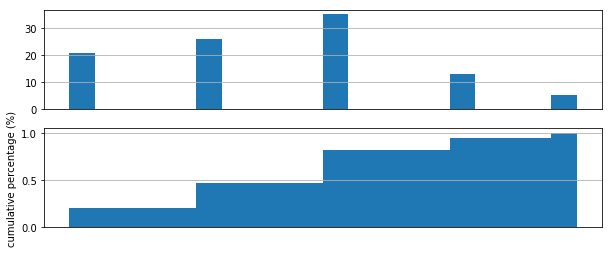

In [126]:
probability(metrics.wavpredac[ metrics.probmax > 0.78 ].dropna());

#### Percent of entries

In [128]:
len(metrics.wavpredac[ metrics.probmax > 0.78 ].dropna())/100

0.77